# SSVEP decoding algorithms

In this notebook, we'll take a look at some algorithms for decoding SSVEP responsens.
We'll make use of the `SSVEPExo` dataset and some existing state-of-the-art SSVEP decoding algorithms.
the dataset and the algorithms are accessed trough in MOABB. You will also implement your own decoding algorithm, based on the feature extraction pipeline implemented in the previous notebook.

To be able to compare all algorithms, we'll only investigate the trials where stimulation is happening and do not attempt to classify the `rest` state.

In [1]:
from moabb.datasets import SSVEPExo

dataset = SSVEPExo()
dataset.event_id= {
    '13': 2,
    '17': 4,
    '21': 3,    
    'rest': 1,
}
interval = dataset.interval
sfreq=256

## Algorithm 1: Canonical Correlation Analysis

Canonical Correlation Analysis [2] is a fast and relatively performant algorithm that finds a spatial filter to isolate the EEG activity oscillating at the frequencies of interest. It works by constructing a spatial filter of which the output maximally correlates with sinusoidal template signals at the frequencies of interest and their harmonics. The code below plots an example of the template signals for the frequencies of interest and their first harmonic.

Text(0.5, 0, 'Time (s)')

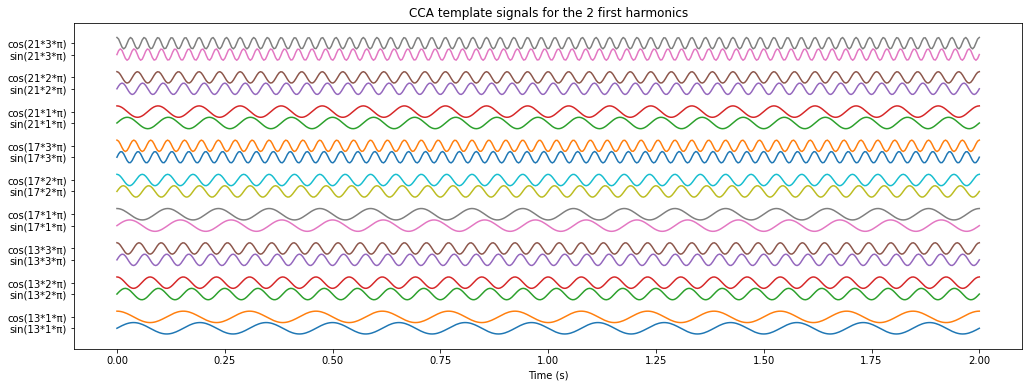

In [2]:
import matplotlib.pyplot as plt
import numpy as np

base_freqs = [13,17,21]
harmonics = [1,2,3]
x = np.linspace(0, 2, sfreq*2)
i = 0
_,ax = plt.subplots(1,1,figsize=(17,6))
y_ticks = []
y_ticklabels = []
for f in base_freqs:
    for h in harmonics: 
        ax.plot(x,np.sin(f*h*np.pi*x)+i*6)
        ax.plot(x,np.cos(f*h*np.pi*x)+i*6+2)
        y_ticks.append(i*6)
        y_ticks.append(i*6+2)
        y_ticklabels.append(f'sin({f}*{h}*π)')
        y_ticklabels.append(f'cos({f}*{h}*π)')
        i+=1
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels)
ax.set_title('CCA template signals for the 2 first harmonics')
ax.set_xlabel('Time (s)')


To use this algorithm, we first let MOABB construct a suiting preprocessing pipeline. The pipeline `paradigm_bandpass` will filter the data between 3Hz and 20Hz. To reduce computational load, we intend to use 2 harmonics to construct the template signals. The highest harmonic of the highest frequency 8.57Hz\*3=25,71Hz falls in this filter band.

In [3]:
from moabb.paradigms import SSVEP

n_classes=3
paradigm_cca = SSVEP(fmin=3, fmax=30, n_classes=n_classes)

Choosing the first 3 classes from all possible events


The CCA classifier for use with MOABB is then constructed:

In [4]:
from sklearn.pipeline import make_pipeline
from moabb.pipelines import SSVEP_CCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import CCA

pipelines_cca = dict()
pipelines_cca["CCA"] = make_pipeline(
    SSVEP_CCA(
        interval=interval,
        freqs=paradigm_cca.used_events(dataset),
        n_harmonics=3
    )
)

## Algorithm 2: Riemannian Geometry

Riemannian Geometry [3] is a relatively new and very performant method in biosignal classification. 
In Riemannian Geometry classifiers, epochs are represented as covariance matrices. They contain a lot of information about the signal, and because they have some nice mathematical properties, they can be classified using optimalization on the Riemannian manifold. While the covariance matrices are highly dimensional, the assumption that they lie on a specific manifold greatly reduces the search space for an optimal solution.

The covariance matrix of a multichannel signal epoch of shape `(n_channels, n_times)` has shape `(n_channels, n_channels)`. Because SSVEP requires us to also include frequency information, we need some specific preprocessing which is taken care of by the `FilterBankSSVEP` processing paradigm.
To obtain SSVEP feature covariance matrices, `FilterBankSSVEP` applies a time-frequency transformation like in the previous notebook to the signal by applying multiple band-pass filters at the frequencies of interest and their harmonics. This results in signal epochs of shape `(n_channels, n_times, n_freqs*n_harmonics)`. MOABB provides an  `ExtendedSSVEPSignal` transformer, which flattens the epochs into shape `(n_chanels*n_freqs*n_harmonics, n_times)`. Finally, covariances of shape `(n_chanels*n_freqs*n_harmonics, n_chanels*n_freqs*n_harmonics)` can then be extracted and classified on the Riemannian manifold.

In [5]:
from moabb.paradigms import FilterBankSSVEP

filter_freqs = np.outer([13,17,21],[1,2,3]).flatten()
print(filter_freqs)
filters = [[f-.1, f+.1] for f in filter_freqs]

paradigm_rg = FilterBankSSVEP(n_classes=n_classes, filters=filters)

Choosing the first 3 classes from all possible events


[13 26 39 17 34 51 21 42 63]


The code below plots the mean extracted covariance for each stimulation frequency. They show clear `(n_channels, n_channels)`-sized blocks around each target frequency and their harmonics. Note how MOABB's `FilterBankSSVEP`does not apply baseline correction in the time frequeny domain, causing the harmonics to have very weak covariance.

/tmp/ipykernel_129876/451011044.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


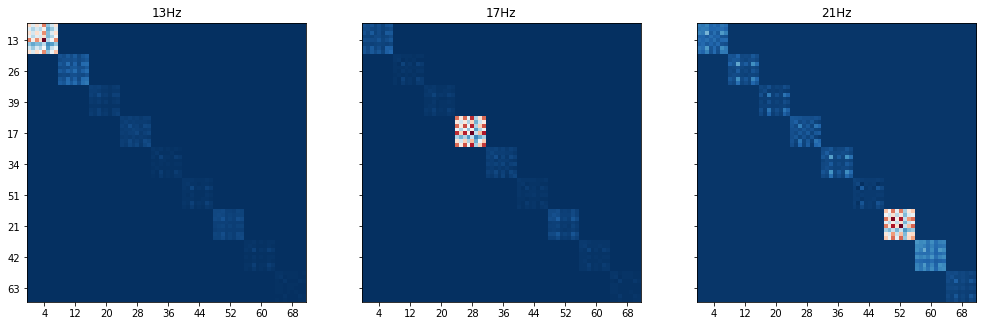

In [6]:
from moabb.pipelines import ExtendedSSVEPSignal
from pyriemann.estimation import Covariances
from mne import concatenate_raws

subj,session = 3, 'session_0'
raw = concatenate_raws(list(dataset.get_data(subjects=[subj])[subj][session].values()))
X_tfr,labels,_ = paradigm_rg.process_raw(raw, dataset)
X_tfr_flat = ExtendedSSVEPSignal().fit_transform(X_tfr, labels)
scm = Covariances(estimator='scm')

fig, axs=plt.subplots(1,len(base_freqs), figsize=(17,6),sharex=True,sharey=True)
for i,l in enumerate(base_freqs):
    cov = np.mean(scm.fit_transform(X_tfr_flat[labels==str(l)]), axis=0)
    axs[i].imshow(cov,cmap=plt.get_cmap('RdBu_r'))
    axs[i].set_title(f'{l}Hz')
    axs[i].grid(False)
    ticks=np.arange(X_tfr.shape[3])*X_tfr.shape[1]+X_tfr.shape[1]/2
    axs[i].set_xticks(ticks)
    axs[i].set_yticks(ticks)
    axs[i].set_yticklabels(filter_freqs)
    axs[i].set_yticklabels(filter_freqs)
fig.show()

Finally, we use `pyRiemann` to construct a classification pipeline that uses Riemannian Geometry to project these covariance matrices to a lower dimensional space (the tangent space). In this low dimensional space, a simple classifier like logistic regression can discriminate the classes.

In [7]:
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression

pipelines_rg = dict()
pipelines_rg["RG+logreg"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)


## Algorithm 3: Frequency band power

In this part, you will reimplement the frequency band power feature extraction method with baselining. Choose a fitting preprocessing paradigm(bandpass `SSVEP`, or `FilterBankSSVEP`) and implement a scikit-learn pipeline that applies baseline correction to each frequency band of each channel of each epoch. As a final step in the pipeline, apply a suiting classifier to classify the extracted features.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import FunctionTransformer

paradigm_bandpower = FilterBankSSVEP(n_classes=n_classes, filters=filters, tmin=-3)

def power_and_baseline(X, y=None, sfreq=128, tmin=-3, baseline=(-2.5, -.5)):
    baseline_start = int((baseline[0]-tmin)*sfreq)
    baseline_end = int((baseline[1]-tmin)*sfreq)        
    baseline_period = X[:,:,baseline_start:baseline_end,:]
    stim_start = max(0, int(-tmin*sfreq))
    stimulation_period = X[:,:,stim_start:,:]
    baseline_power = np.mean(baseline_period**2, axis=(1,2))
    stimulation_power = np.mean(stimulation_period**2, axis=(1,2))
    return np.log(stimulation_power/baseline_power)

pipelines_bandpower = dict()
pipelines_bandpower['power+logreg'] = make_pipeline(
    FunctionTransformer(power_and_baseline),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)

Choosing the first 3 classes from all possible events


## Evaluate algorithm performance

You can run the following snippets to evaluate and compare the performance of your algorithms.

In [11]:
from moabb.evaluations import WithinSessionEvaluation

evaluation_cca = WithinSessionEvaluation(
    paradigm=paradigm_cca,
    datasets=dataset,
    suffix="ssvep_workshop_cca",
    overwrite=False
)
results_cca = evaluation_cca.process(pipelines_cca)
results_cca

SSVEP Exoskeleton-WithinSession: 100%|█|


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.646667,0.031806,48.0,1,session_0,8,1,SSVEP Exoskeleton,CCA
1,0.457778,0.032760,48.0,2,session_0,8,1,SSVEP Exoskeleton,CCA
2,0.933333,0.031507,48.0,3,session_0,8,1,SSVEP Exoskeleton,CCA
3,0.855556,0.035912,48.0,4,session_0,8,1,SSVEP Exoskeleton,CCA
4,0.628889,0.033949,48.0,5,session_0,8,1,SSVEP Exoskeleton,CCA
5,0.668889,0.030916,48.0,6,session_0,8,1,SSVEP Exoskeleton,CCA
6,0.918095,0.050224,72.0,7,session_0,8,1,SSVEP Exoskeleton,CCA
7,0.793333,0.034704,48.0,8,session_0,8,1,SSVEP Exoskeleton,CCA
8,0.746667,0.034755,48.0,9,session_0,8,1,SSVEP Exoskeleton,CCA
9,0.531053,0.062775,96.0,10,session_0,8,1,SSVEP Exoskeleton,CCA


In [12]:
evaluation_rg = WithinSessionEvaluation(
    paradigm=paradigm_rg,
    datasets=dataset,
    suffix="ssvep_workshop_rg",
    overwrite=False
)
results_rg = evaluation_rg.process(pipelines_rg)
results_rg

SSVEP Exoskeleton-WithinSession: 100%|█|


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.773333,1.294912,48.0,1,session_0,8,1,SSVEP Exoskeleton,RG+logreg
1,0.440000,1.208029,48.0,2,session_0,8,1,SSVEP Exoskeleton,RG+logreg
2,0.977778,1.524016,48.0,3,session_0,8,1,SSVEP Exoskeleton,RG+logreg
3,0.957778,1.455777,48.0,4,session_0,8,1,SSVEP Exoskeleton,RG+logreg
4,0.773333,1.429880,48.0,5,session_0,8,1,SSVEP Exoskeleton,RG+logreg
5,0.831111,1.479813,48.0,6,session_0,8,1,SSVEP Exoskeleton,RG+logreg
6,0.985714,2.477118,72.0,7,session_0,8,1,SSVEP Exoskeleton,RG+logreg
7,0.980000,2.015938,48.0,8,session_0,8,1,SSVEP Exoskeleton,RG+logreg
8,1.000000,1.793463,48.0,9,session_0,8,1,SSVEP Exoskeleton,RG+logreg
9,0.957895,2.595332,96.0,10,session_0,8,1,SSVEP Exoskeleton,RG+logreg


In [17]:
evaluation_bandpower = WithinSessionEvaluation(
    paradigm=paradigm_bandpower,
    datasets=dataset,
    suffix="ssvep_workshop_bandpower",
    overwrite=True
)
results_bandpower = evaluation_bandpower.process(pipelines_bandpower)
results_bandpower

SSVEP Exoskeleton-WithinSession: 100%|█|


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.771111,0.018689,48.0,1,session_0,8,1,SSVEP Exoskeleton,power+logreg
1,0.422222,0.019829,48.0,2,session_0,8,1,SSVEP Exoskeleton,power+logreg
2,0.915556,0.017611,48.0,3,session_0,8,1,SSVEP Exoskeleton,power+logreg
3,0.786667,0.016856,48.0,4,session_0,8,1,SSVEP Exoskeleton,power+logreg
4,0.480000,0.012781,48.0,5,session_0,8,1,SSVEP Exoskeleton,power+logreg
5,0.484444,0.016502,48.0,6,session_0,8,1,SSVEP Exoskeleton,power+logreg
6,0.887619,0.022413,72.0,7,session_0,8,1,SSVEP Exoskeleton,power+logreg
7,0.662222,0.013167,48.0,8,session_0,8,1,SSVEP Exoskeleton,power+logreg
8,0.708889,0.013015,48.0,9,session_0,8,1,SSVEP Exoskeleton,power+logreg
9,0.522632,0.035423,96.0,10,session_0,8,1,SSVEP Exoskeleton,power+logreg


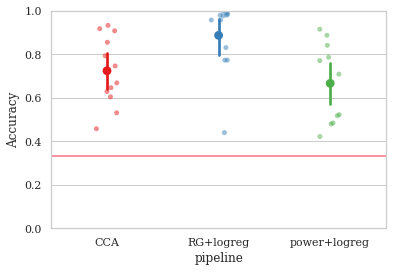

In [18]:
import seaborn as sns
import pandas as pd

results = pd.concat([results_cca, results_rg, results_bandpower])
ax = sns.stripplot(data=results, y="score", x="pipeline", zorder=1, alpha=.5, palette="Set1")
ax = sns.pointplot(data=results, y="score", x="pipeline" , palette="Set1")
ax.set_ylabel("Accuracy")
ax.axhline(1/n_classes)
_ = ax.set_ylim(0,1)

## References

[2] Bin, G., Gao, X., Yan, Z., Hong, B., & Gao, S. (2009). An online multi-channel SSVEP-based brain-computer interface using a canonical correlation analysis method. Journal of neural engineering, 6(4), 046002. https://doi.org/10.1088/1741-2560/6/4/046002

[3] Kalunga, E. K., Chevallier, S., Barthélemy, Q., Djouani, K., Monacelli, E., & Hamam, Y. (2016). Online SSVEP-based BCI using Riemannian geometry. Neurocomputing, 191, 55-68. https://doi.org/10.1016/j.neucom.2016.01.007